This notebook implements the OG Casagrandi and  Rinaldi notebook (A Minimal Model for Forest Fire Regimes)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rain_forests =  {"beta_u" : 23,
    "beta_l" : 23,
    "delta_u" : 30,
    "delta_l" : 30,
    "k_u" : 2,
    "k_l" : 3,
    "r_u" : 0.15,
    "r_l" : 0.25,
    "alpha" : 0.07,
    "gamma_u" : 5,
    "gamma_l" : 5 ,  
    "h_uu" : 0.045,
    "h_ul" : 0.045,   
    "h_ll" : 0.045,    
    "h_lu" : 0.045 }

boreal_forests = {"beta_u" : 18,
    "beta_l" : 20,
    "delta_u" : 16.5,
    "delta_l" : 21,
    "k_u" : 3,
    "k_l" : 0.1,
    "r_u" : 0.1,
    "r_l" : 0.3,
    "alpha" : 0.045,
    "gamma_u" : 0.1,
    "gamma_l" : 0.02 ,
    "h_uu" : 0.045,
    "h_ul" : 0.045,   
    "h_ll" : 0.0015,    
    "h_lu" : 0.0015}


savannas = { "beta_u" : 50,
    "beta_l" : 80,
    "delta_u" : 53,
    "delta_l" : 72,
    "k_u" : 0.5,
    "k_l" : 0.4,
    "r_u" : 0.8,
    "r_l" : 2.0,
    "alpha" : 2.,
    "gamma_u" : 1,
    "gamma_l" : 1,
    "h_uu" : 0.0075,
    "h_ul" : 0.0075,   
    "h_ll" : 0.006,   
    "h_lu" : 0.006,
    "G_u" : 0.5,
    "G_l" : 0.35,
    "R_u" : 0.05,
    "R_l" : 0.05,
    "spin" : 35 
            }     


In [3]:


# mediterranean forests
mforest = {
    "r_u" :0.25,
    "r_l" :1.5,
    "k_u" :1,
    "k_l" :1,    
    "beta_u" : 25,
    "beta_l" : 25,
    "delta_u" : 21.25,
    "delta_l" : 21.25,
    "alpha" :0.5,
    "gamma_u" :0.1,
    "gamma_l" :0.1,
    "h_uu" :0.015,
    "h_ul" :0.015,
    "h_ll" :0.015,
    "h_lu" :0.015,
    "G_u" : 0.1,
    "G_l" : 0.4,
    "R_u" : 0.1,
    "R_l" : 0.1,
    "spin" : 0}



In [4]:
class RCSR:
    """
    Default is rainforest!
    """

    def __init__(self, params = {}):
        """
        """
        default =  {"beta_u" : 23,
            "beta_l" : 23,
            "delta_u" : 30,
            "delta_l" : 30,
            "k_u" : 2.,
            "k_l" : 3.,
            "r_u" : 0.15,
            "r_l" : 0.25,
            "alpha" : 0.07,
            "gamma_u" : 5,
            "gamma_l" : 5,  
            "h_uu" : 0.045,
            "h_ul" : 0.045,  
            "h_ll" : 0.045,    
            "h_lu" : 0.045,
            "dt" : 0.01,
            "tmax" : 1000,
                   }


        default.update(params)
        
        
        for k, v in default.items():
             setattr(self, k, v)
                
        self.G_u_list = []
        self.R_u_list = []
        self.G_l_list = []
        self.R_l_list = []        
        self.times = np.arange(0, self.tmax + self.dt, self.dt)
        self.ti = np.where(self.times > self.spin)[0][0]
        self.nt_steps = len(self.times)
        
    def __repr__(self):
        attrs = vars(self)
        return  '{' + ',\n  '.join("%s: %s" % item for item in attrs.items()) +'}'                
    
    def g_u(self):
        """
        upper layer growth rate
        """
        return self.r_u*self.G_u*(1-self.G_u/self.k_u)
    
    def g_l(self):
        """
        lower layer growth rate
        """
        return self.r_l*self.G_l*(1-self.G_l/self.k_l) - self.alpha*self.G_l*self.G_u

    
    def f_u(self):
        """
        ignition rate
        """
        upper = self.beta_u*self.G_u/(self.G_u + self.h_uu)*self.R_u
        lower = self.gamma_u*self.G_u/(self.G_u + self.h_ul)*self.R_l        
        return upper + lower

    
    def f_l(self):
        """
        lower layer ignition rate
        """
        upper = self.beta_l*self.G_l/(self.G_l + self.h_ll)*self.R_l
        lower = self.gamma_l*self.G_l/(self.G_l + self.h_lu)*self.R_u        
        return upper + lower

    
    def e_u(self):
        """
        upper layer extinction rate
        """
        return self.delta_u*self.R_u

       
    def e_l(self):
        """
        lower layer extinction rate
        """
        return self.delta_l*self.R_l
    
    def derivs(self):
        
        self.G_u_dot = self.g_u()  - self.f_u()
        self.R_u_dot = self.f_u() - self.e_u() 
        
        self.G_l_dot = self.g_l() - self.f_l()        
        self.R_l_dot = self.f_l() - self.e_l()     
        


    def timestep(self):
        
        self.derivs()
        
        G_u = self.G_u + self.G_u_dot*self.dt
        R_u = self.R_u + self.R_u_dot*self.dt        
        
        G_l = self.G_l + self.G_l_dot*self.dt
        R_l = self.R_l + self.R_l_dot*self.dt        
        
        self.G_l = G_l
        self.G_u = G_u
        self.R_l = R_l
        self.R_u = R_u
        
        self.G_u_list.append(self.G_u)
        self.R_u_list.append(self.R_u)   
        
        self.G_l_list.append(self.G_l)
        self.R_l_list.append(self.R_l)        

        
    def run(self):
        
        for i in range(self.nt_steps):
            self.timestep()
            
    def plot_G_l(self, ax):
        ax.plot(self.times[self.ti:], self.G_l_list[self.ti:], label = "$G_l$")
    
    def plot_G_u(self, ax):
        ax.plot(self.times[self.ti:], self.G_u_list[self.ti:], label = "$G_u$")        

    def plot_G(self, ax):
        self.plot_G_l(ax)
        self.plot_G_u(ax)   
        ax.legend(fontsize = 14)
    
    def plot_A(self, ax):
        ax.plot(self.G_l_list[self.ti:], self.G_u_list[self.ti:],".", ms = 1, label = "$G_u$")        
       
    def plot_R_l(self, ax):
        ax.plot(self.times[self.ti:], self.R_l_list[self.ti:], label = "$R_l$")
    
    def plot_R_u(self, ax):
        ax.plot(self.times[self.ti:], self.R_u_list[self.ti:], label = "$R_u$")        

    def plot_R(self, ax):
        self.plot_R_l(ax)
        self.plot_R_u(ax)   
        ax.legend(fontsize = 14)    
    
    def plot(self,axes):
        self.plot_G(axes[0])
        self.plot_A(axes[1])        
        self.plot_R(axes[2])


/Users/octavia/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


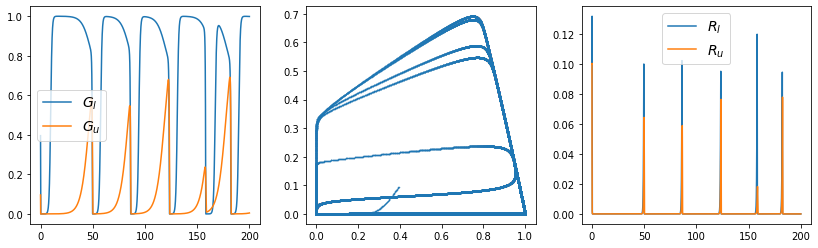

In [5]:
fig, axes = plt.subplots(1,3, figsize = (14,4) )

mforest["dt"] = 0.001
mforest["tmax"] = 200
p = RCSR(mforest)
p.run()

p.plot(axes)
